# Laboratory Final Project

- *Introduction to Statistical Computing*
- Author: Elena Conderana & Sergio Cuenca
- Date: XX/03/2025

---

## 1. Research questions

- **Which demographic groups are most affected by cost barriers to healthcare?**
- Hypothesis Research Question

---

## 2. Data
In this section, sampling techniques shall be used on the data to obtain a sample of the
population from which we can draw conclusions on the whole dataset/US population. Here are
some ideas for questions that may be answered (you can add more):
- Describe the sampling method, which technique you have used and why.
- May the results of your EDA be generalized to the whole population from the sample you
have chosen?
- Discuss potential sources of bias based on the dataset description, how can these biases
affect your conclusions?

In [ ]:
import scipy.stats as stats
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [37]:
df = pd.read_csv('brfss2013.csv', sep=",", encoding='cp1252', on_bad_lines='skip', low_memory=False)

### 2.1. CI Data Analysis

In [38]:
df_ci = pd.DataFrame()
df_ci['medical_cost_barrier'] = df['medcost']
df_ci['health_insurance'] = df['hlthpln1']
df_ci['personal_doctor'] = df['persdoc2']
df_ci['sex'] = df['sex']
df_ci['age_group'] = df['X_ageg5yr']
df_ci['state'] = df['X_state']
df_ci['income_level'] = df['income2']
df_ci['education_level'] = df['educa']
df_ci['employment_status'] = df['employ1']
df_ci['general_health'] = df['genhlth']
df_ci['physically_unwell_days'] = df['physhlth']
df_ci['mentally_unwell_days'] = df['menthlth']
df_ci['activity_limited_days'] = df['poorhlth']

na_counts = df_ci.isna().sum()
print("Missing values per column:\n", na_counts)

Missing values per column:
 medical_cost_barrier        1221
health_insurance            1904
personal_doctor             1801
sex                            7
age_group                   4730
state                          0
income_level               71426
education_level             2274
employment_status           3386
general_health              1985
physically_unwell_days     10957
mentally_unwell_days        8627
activity_limited_days     243153
dtype: int64


Drop  rows where key variables are missing (especially medical_cost_barrier, final_weight, and stratification variables like income_level, sex)

- Cost barriers are linked to income and sex: Without stratification, the sample might under- or over-represent key groups
- Stratification ensures proportional representation: Low-income and high-income groups appear in the same proportions as the population
- Leads to more accurate and generalizable CIs: We want the resulting sample to mimic the actual population structure

In [39]:
from sklearn.model_selection import train_test_split

# Drop rows with missing key values
df_clean = df_ci.dropna(subset=['medical_cost_barrier', 'income_level', 'employment_status'])

# Stratified sampling (10%) by income and sex
df_ci_sampled, _ = train_test_split(
    df_clean,
    test_size=0.9,
    stratify=df_clean[['income_level', 'employment_status']],
    random_state=42
)

print("Sample shape:", df_ci_sampled.shape)

Sample shape: (41835, 13)


We defined a cleaned working population (df_clean) by removing rows with missing values in essential variables required for stratified sampling and inference. From this cleaned dataset, we drew a 10% stratified random sample (df_ci_sampled) based on income and sex to ensure representativeness for confidence interval estimation and exploratory data analysis. Missing or invalid entries in key variables (e.g., medical cost barrier, sex, final weight) were excluded. This stratified sample allows us to estimate the proportion of U.S. adults who reported cost as a barrier to medical care with greater precision and confidence.

Although some variables have missing values (notably income and activity-limited days), the final sample retains sufficient size and structure to support inference. Potential biases due to missing data are addressed in the following section.

In [40]:
def category_distribution(df, column):
    return df[column].value_counts(normalize=True).sort_index()

# Compare proportions
print("Full dataset - Income distribution:\n", category_distribution(df_clean, 'income_level'))
print("Sample - Income distribution:\n", category_distribution(df_ci_sampled, 'income_level'))

print("\nFull dataset - Sex distribution:\n", category_distribution(df_clean, 'sex'))
print("Sample - Sex distribution:\n", category_distribution(df_ci_sampled, 'sex'))

Full dataset - Income distribution:
 $75,000 or more      0.276353
Less than $10,000    0.060181
Less than $15,000    0.063477
Less than $20,000    0.082732
Less than $25,000    0.099139
Less than $35,000    0.116187
Less than $50,000    0.146486
Less than $75,000    0.155445
Name: income_level, dtype: float64
Sample - Income distribution:
 $75,000 or more      0.276324
Less than $10,000    0.060141
Less than $15,000    0.063488
Less than $20,000    0.082730
Less than $25,000    0.099128
Less than $35,000    0.116242
Less than $50,000    0.146456
Less than $75,000    0.155492
Name: income_level, dtype: float64

Full dataset - Sex distribution:
 Female    0.57618
Male      0.42382
Name: sex, dtype: float64
Sample - Sex distribution:
 Female    0.574352
Male      0.425648
Name: sex, dtype: float64


We validated the representativeness of our sample by comparing the distributions of the stratification variables — income level and sex — between the sample and the full cleaned dataset.
The distributions matched almost perfectly, with absolute differences in proportions of less than 0.001 for all categories. This confirms that our stratified sampling approach successfully preserved the population structure, ensuring that the results of our EDA and confidence interval estimation can be generalized to the broader U.S. adult population surveyed by BRFSS in 2013.

### 2.2. Hypothesis Data Analysis

In [135]:
# Extraction of columns of interes
df_hypothesis = pd.DataFrame()
df_hypothesis['vet'] = df['veteran3']
df_hypothesis['sex'] = df['sex']
df_hypothesis['age'] = df['X_ageg5yr']
df_hypothesis['avgDrinksDay'] = df['avedrnk2']
df_hypothesis['employment'] = df['employ1']
df_hypothesis['lifeSatisfaction'] = df['lsatisfy']
df_hypothesis['bingeDrinking'] = df['X_rfbing5']

In [96]:
# Counting of NaN values
na_counts = df_hypothesis.isna().sum()
print(na_counts)

vet                    746
sex                      7
age                   4730
avgDrinksDay        260590
employment            3386
lifeSatisfaction    480104
bingeDrinking        23731
dtype: int64


In [141]:
# Drop NaN values
df_for_sampling = df_hypothesis.dropna(subset=['vet','sex','age','employment','bingeDrinking']).copy()

df_for_sampling['vet_flag'] = df_for_sampling['vet'].map({'Yes': 1, 'No': 2}).astype(int)

# Proportions of veterans and non-veterans in the complete dataset
total_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 1])
total_non_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 2])
total_population = len(df_for_sampling)

proportion_veterans = total_veterans / total_population
proportion_non_veterans = total_non_veterans / total_population

# Sample sizes
total_sample_size = int(0.2 * total_population)
n_veterans = int(total_sample_size * proportion_veterans)
n_non_veterans = int(total_sample_size * proportion_non_veterans)

# Separate into strata
veterans = df_for_sampling[df_for_sampling['vet_flag'] == 1]
non_veterans = df_for_sampling[df_for_sampling['vet_flag'] == 2]

# Perform random sampling within each stratum
veteran_sample = veterans.sample(n=min(n_veterans, len(veterans)), random_state=42)
non_veteran_sample = non_veterans.sample(n=min(n_non_veterans, len(non_veterans)), random_state=42)

df_hypothesis_sampled = pd.concat([veteran_sample, non_veteran_sample])
df_hypothesis = df_hypothesis_sampled.copy()

# Convert categorical variables
df_hypothesis['vet_label'] = df_hypothesis['vet'].map({'Yes':1, 'No':0})
life_satisfaction_mapping = {
    'Very satisfied': 5,
    'Satisfied': 4,
    'Neutral': 3,
    'Dissatisfied': 2,
    'Very dissatisfied': 1
}
df_hypothesis['lifeSatisfaction_label'] = df_hypothesis['lifeSatisfaction'].map(life_satisfaction_mapping)

print(f"Sample size (veterans): {len(veteran_sample)}")
print(f"Sample size (non-veterans): {len(non_veteran_sample)}")
print(f"Total sample size: {len(df_hypothesis)}")

Sample size (veterans): 2312
Sample size (non-veterans): 16195
Total sample size: 18507


In [165]:
def category_distribution(df, column):
    return df[column].value_counts(normalize=True).sort_index()

# Compare proportions
print("Full dataset - Veteran distribution:\n", category_distribution(df, 'veteran3'))
print("Sample - Veteran distribution:\n", category_distribution(df_hypothesis_sampled, 'vet'))


Full dataset - Veteran distribution:
 No     0.874863
Yes    0.125137
Name: veteran3, dtype: float64
Sample - Veteran distribution:
 No     0.875074
Yes    0.124926
Name: vet, dtype: float64


---

## 3. EDA
In this section, perform an explorative analysis to answer the proposed questions in the previous
section. Justify the results and draw conclusions based on this analysis.

In [45]:
import seaborn as sns

# Set style and palette
sns.set_theme(style="whitegrid")

### 3.1. CI EDA

In [46]:
cost_labels = {"Yes": "Yes", "No": "No"}
sex_labels = {"Male": "Male", "Female": "Female"}
income_labels = {
    '$75,000 or more': '≥75K', 'Less than $75,000': '<75K', 'Less than $50,000': '<50K',
    'Less than $35,000': '<35K', 'Less than $25,000': '<25K', 'Less than $20,000': '<20K',
    'Less than $15,000': '<15K', 'Less than $10,000': '<10K'
}
education_labels = {
    'College 4 years or more (College graduate)': 'College Grad',
    'College 1 year to 3 years (Some college or technical school)': 'Some College',
    'Grade 12 or GED (High school graduate)': 'High School',
    'Grades 9 though 11 (Some high school)': 'Some HS',
    'Grades 1 through 8 (Elementary)': 'Elementary',
    'Never attended school or only kindergarten': 'No School'
}
employment_labels = {
    'Employed for wages': 'Employed', 'Self-employed': 'Self-employed',
    'Retired': 'Retired', 'A homemaker': 'Homemaker', 'A student': 'Student',
    'Out of work for less than 1 year': '<1yr Unemp', 'Out of work for 1 year or more': '≥1yr Unemp',
    'Unable to work': 'Unable'
}
age_labels = {
    'Age 18 to 24': '18-24', 'Age 25 to 29': '25-29', 'Age 30 to 34': '30-34',
    'Age 35 to 39': '35-39', 'Age 40 to 44': '40-44', 'Age 45 to 49': '45-49',
    'Age 50 to 54': '50-54', 'Age 55 to 59': '55-59', 'Age 60 to 64': '60-64',
    'Age 65 to 69': '65-69', 'Age 70 to 74': '70-74', 'Age 75 to 79': '75-79',
    'Age 80 or older': '80+'
}
insurance_labels = {
    'Yes': 'Insured', 'No': 'Uninsured'
}
doctor_labels = {
    'Yes, only one': 'One doctor', 'More than one': 'Multiple doctors', 'No': 'No doctor'
}
health_labels = {
    'Excellent': 'Excellent', 'Very good': 'Very good', 'Good': 'Good',
    'Fair': 'Fair', 'Poor': 'Poor'
}

In [47]:
df_plot = df_ci_sampled.copy()

df_plot['cost_barrier_label'] = df_plot['medical_cost_barrier'].map(cost_labels)
df_plot['sex_label'] = df_plot['sex'].map(sex_labels)
df_plot['income_label'] = df_plot['income_level'].map(income_labels)
df_plot['education_label'] = df_plot['education_level'].map(education_labels)
df_plot['employment_label'] = df_plot['employment_status'].map(employment_labels)
df_plot['age_label'] = df_plot['age_group'].map(age_labels)
df_plot['insurance_label'] = df_plot['health_insurance'].map(insurance_labels)
df_plot['doctor_label'] = df_plot['personal_doctor'].map(doctor_labels)
df_plot['health_label'] = df_plot['general_health'].map(health_labels)

income_order = ['≥75K', '<75K', '<50K', '<35K', '<25K', '<20K', '<15K', '<10K']
edu_order = list(education_labels.values())
emp_order = list(employment_labels.values())
age_order = list(age_labels.values())
health_order = ['Excellent', 'Very good', 'Good', 'Fair', 'Poor']
insurance_order = ['Insured', 'Uninsured']
doctor_order = ['One doctor', 'Multiple doctors', 'No doctor']

# Define como categorías ordenadas
df_plot['income_label'] = pd.Categorical(df_plot['income_label'], categories=income_order, ordered=True)
df_plot['education_label'] = pd.Categorical(df_plot['education_label'], categories=edu_order, ordered=True)
df_plot['employment_label'] = pd.Categorical(df_plot['employment_label'], categories=emp_order, ordered=True)
df_plot['age_label'] = pd.Categorical(df_plot['age_label'], categories=age_order, ordered=True)
df_plot['health_label'] = pd.Categorical(df_plot['health_label'], categories=health_order, ordered=True)
df_plot['insurance_label'] = pd.Categorical(df_plot['insurance_label'], categories=insurance_order, ordered=True)
df_plot['doctor_label'] = pd.Categorical(df_plot['doctor_label'], categories=doctor_order, ordered=True)

df_plot = df_plot.drop(columns=['income_level', 'education_level', 'employment_status', 'age_group', 
                                'health_insurance', 'personal_doctor', 'general_health', 'sex', 'medical_cost_barrier'])

Before making graphs and exploring the data, it is essential to check for biases that may be present in the gathered sample. Identifying and addressing biases ensures that the analysis and conclusions drawn are representative and reliable.

#### 3.1.1. Self-Report Bias – General Health Distribution

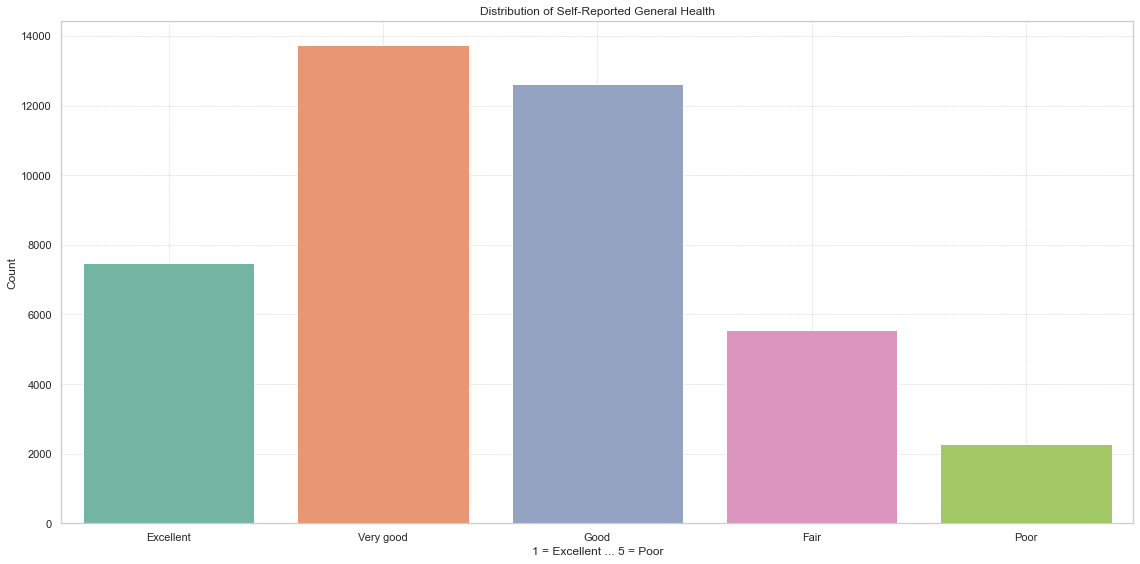

In [48]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set up the color palette
palette = sns.color_palette('Set2', n_colors=5)

# Ensure 'general_health' is a categorical variable with the right order
df_ci_sampled['general_health'] = pd.Categorical(
    df_ci_sampled['general_health'],
    categories=['Excellent', 'Very good', 'Good', 'Fair', 'Poor'],
    ordered=True
)

fig, ax = plt.subplots(figsize=(16, 8))

# Plot on the defined axis
sns.countplot(data=df_ci_sampled, x='general_health', palette=palette, ax=ax)

# Add title and labels
ax.set_title('Distribution of Self-Reported General Health')
ax.set_xlabel('1 = Excellent ... 5 = Poor')
ax.set_ylabel('Count')
ax.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

BRFSS relies entirely on self-reported data, which introduces the risk of self-report bias. Individuals may overstate healthy behaviors, underreport unhealthy ones, or misremember their experiences. This is particularly relevant for sensitive questions like mental health, healthcare access, or income.
To examine this, we analyzed the distribution of self-reported general health. The results show a strong skew toward positive responses — with most respondents reporting “Very Good” or “Good” health, and very few selecting “Poor.” This skew suggests a social desirability bias, where individuals present themselves in a more favorable light

#### 3.1.2. Coverage Bias – Top/Bottom States by Response %

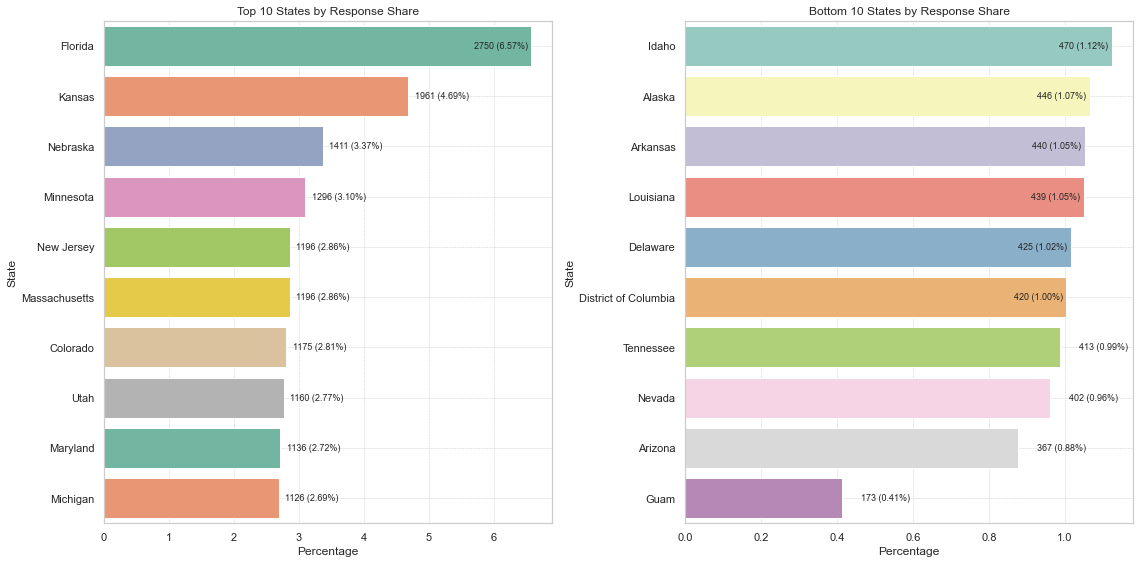

In [49]:
state_counts = df_ci_sampled['state'].value_counts(normalize=True) * 100
state_counts_abs = df_ci_sampled['state'].value_counts()

top_states = state_counts.head(10)
bottom_states = state_counts.tail(10)

palette_left = sns.color_palette("Set2", n_colors=10)
palette_right = sns.color_palette("Set3", n_colors=10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(x=top_states.values, y=top_states.index, ax=axes[0], palette=palette_left)
axes[0].set_title("Top 10 States by Response Share")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("State")
axes[0].grid(True, which="both", ls="--", linewidth=0.5)

for i, state in enumerate(top_states.index):
    percent = top_states[state]
    count = state_counts_abs[state]
    text = f"{count} ({percent:.2f}%)"
    x_offset = 0.1 if percent < 6.5 else -0.05
    ha = 'left' if percent < 6.5 else 'right'
    axes[0].text(percent + x_offset, i, text, va='center', ha=ha, fontsize=9)

sns.barplot(x=bottom_states.values, y=bottom_states.index, ax=axes[1], palette=palette_right)
axes[1].set_title("Bottom 10 States by Response Share")
axes[1].set_xlabel("Percentage")
axes[1].set_ylabel("State")
axes[1].grid(True, which="both", ls="--", linewidth=0.5)

for i, state in enumerate(bottom_states.index):
    percent = bottom_states[state]
    count = state_counts_abs[state]
    text = f"{count} ({percent:.2f}%)"
    x_offset = 0.05 if percent < 1 else -0.01
    ha = 'left' if percent < 1 else 'right'
    axes[1].text(percent + x_offset, i, text, va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.show()

The BRFSS is a telephone-based survey targeting non-institutionalized U.S. adults. As a result, the dataset may exclude certain vulnerable groups, such as people in prisons, nursing homes, or without reliable phone access.
To explore potential coverage bias, we examined the state distribution in the dataset. Some states are significantly overrepresented (e.g., Florida with 6.85%) while others are underrepresented (e.g., Alaska, Tennesse, D.C., each with less than 1%). Although these differences may reflect sampling quotas or population size, they suggest that certain regions or populations may be less represented, potentially affecting national estimates of healthcare access and cost barriers.

#### 3.1.3. Missing Data Bias - Nonresponse by Variable

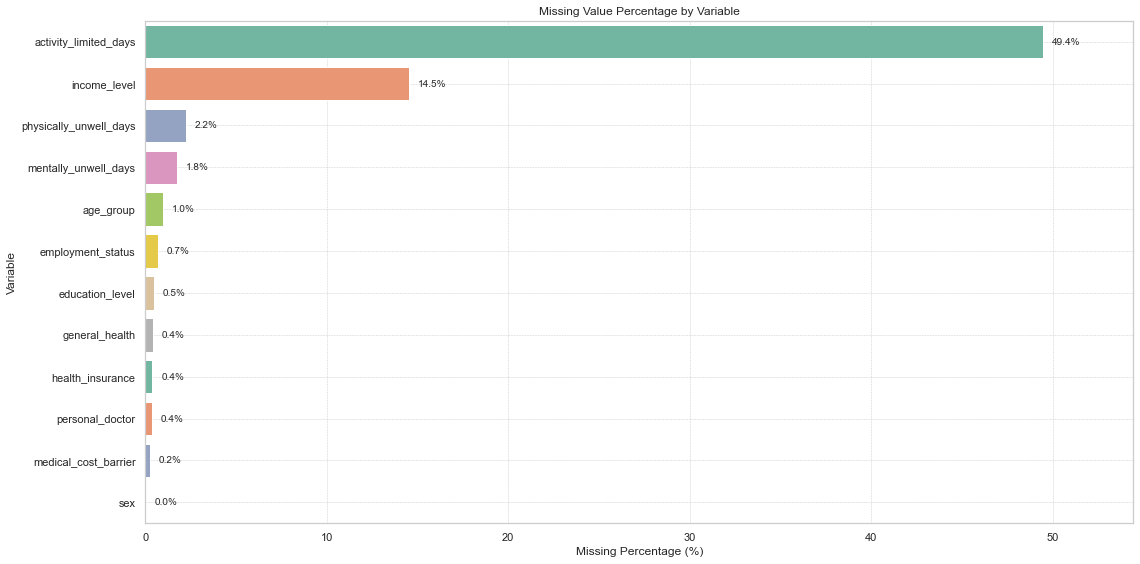

In [50]:
na_summary = df_ci.isna().mean().sort_values(ascending=False) * 100
na_summary_filtered = na_summary[na_summary > 0]

plt.figure(figsize=(16, 8))
ax = sns.barplot(x=na_summary_filtered.values, y=na_summary_filtered.index, palette="Set2")

for i, (value, label) in enumerate(zip(na_summary_filtered.values, na_summary_filtered.index)):
    ax.text(value + 0.5, i, f"{value:.1f}%", va='center', ha='left', fontsize=10)

plt.title("Missing Value Percentage by Variable")
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Variable")
plt.xlim(0, max(na_summary_filtered.values) + 5)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


One notable source of potential bias in our dataset is missing data, particularly in the variable activity_limited_days, which is missing in approximately 49% of the cases. This high rate of nonresponse may be due to survey structure (e.g., optional modules or follow-up logic).

Additionally, income_level is missing in 14.5% of respondents, and this is especially relevant as income is one of the key variables related to healthcare access. To mitigate bias, we excluded missing income cases before stratified sampling and confidence interval estimation. However, we acknowledge that if the missingness is not random — for example, if lower-income individuals are less likely to report income — this could introduce systematic bias and underrepresent certain vulnerable groups.
Other variables like mental_health and employment_status had low levels of missing data and were handled using available-case analysis, dropping rows only when those variables were directly involved in a particular analysis.


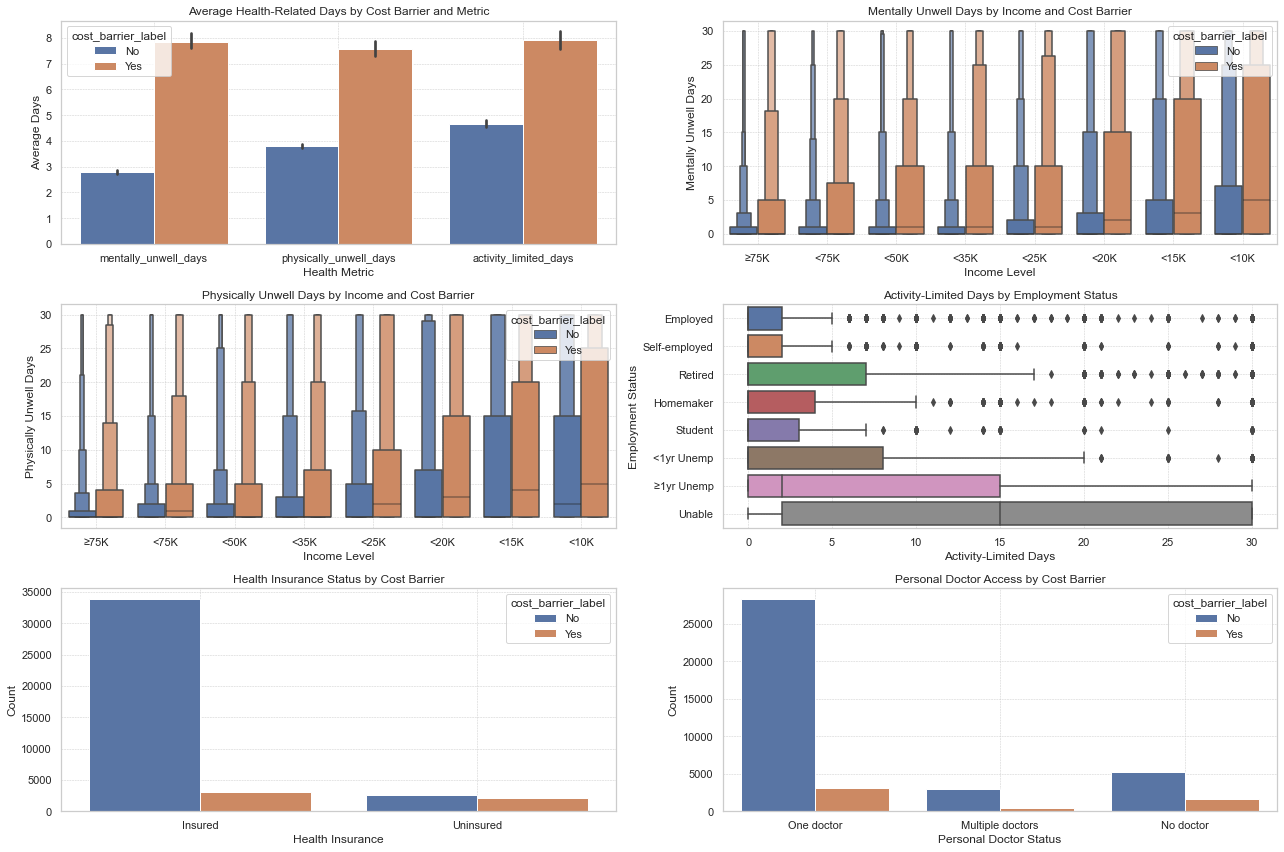

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Bar plot: Health-related days by Cost Barrier
df_melted = df_plot.melt(
    id_vars=['cost_barrier_label', 'sex_label'],
    value_vars=[
        'mentally_unwell_days',
        'physically_unwell_days',
        'activity_limited_days'
    ],
    var_name='health_metric',
    value_name='days'
)
sns.barplot(
    data=df_melted,
    x='health_metric',
    y='days',
    hue='cost_barrier_label',
    ax=axes[0, 0],
    dodge=True
)
axes[0, 0].set_title("Average Health-Related Days by Cost Barrier and Metric")
axes[0, 0].set_xlabel("Health Metric")
axes[0, 0].set_ylabel("Average Days")
axes[0, 0].grid(True, ls='--', linewidth=0.5)

# 2. Boxenplot: Mentally Unwell Days by Income & Cost Barrier
sns.boxenplot(
    data=df_plot,
    x='income_label',
    y='mentally_unwell_days',
    hue='cost_barrier_label',
    order=income_order,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Mentally Unwell Days by Income and Cost Barrier")
axes[0, 1].set_xlabel("Income Level")
axes[0, 1].set_ylabel("Mentally Unwell Days")
axes[0, 1].tick_params(axis='x')
axes[0, 1].grid(True, ls="--", linewidth=0.5)

# 3. Boxenplot: Physically Unwell Days by Income & Cost Barrier
sns.boxenplot(
    data=df_plot,
    x='income_label',
    y='physically_unwell_days',
    hue='cost_barrier_label',
    order=income_order,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Physically Unwell Days by Income and Cost Barrier")
axes[1, 0].set_xlabel("Income Level")
axes[1, 0].set_ylabel("Physically Unwell Days")
axes[1, 0].tick_params(axis='x')
axes[1, 0].grid(True, ls='--', linewidth=0.5)

# 4. Boxplot: Activity-Limited Days by Employment
sns.boxplot(
    data=df_plot,
    y='employment_label',
    x='activity_limited_days',
    ax=axes[1, 1]
)
axes[1, 1].set_title("Activity-Limited Days by Employment Status")
axes[1, 1].set_xlabel("Activity-Limited Days")
axes[1, 1].set_ylabel("Employment Status")
axes[1, 1].grid(True, ls='--', linewidth=0.5)

# 5. Countplot: Health Insurance by Cost Barrier
sns.countplot(
    data=df_plot,
    x='insurance_label',
    hue='cost_barrier_label',
    ax=axes[2, 0]
)
axes[2, 0].set_title("Health Insurance Status by Cost Barrier")
axes[2, 0].set_xlabel("Health Insurance")
axes[2, 0].set_ylabel("Count")
axes[2, 0].grid(True, ls='--', linewidth=0.5)

# 6. Countplot: Personal Doctor by Cost Barrier
sns.countplot(
    data=df_plot,
    x='doctor_label',
    hue='cost_barrier_label',
    ax=axes[2, 1]
)
axes[2, 1].set_title("Personal Doctor Access by Cost Barrier")
axes[2, 1].set_xlabel("Personal Doctor Status")
axes[2, 1].set_ylabel("Count")
axes[2, 1].tick_params(axis='x')
axes[2, 1].grid(True, ls='--', linewidth=0.5)

plt.tight_layout()
plt.show()


To assess the impact of cost-related access barriers on health, we examined self-reported physically and mentally unwell days, along with activity-limited days, across income levels, cost barriers, and employment status

Key Findings:
- Average Health Days by Cost Barrier and Metric: Individuals facing cost barriers consistently report more mentally unwell, physically unwell, and activity-limited days compared to those without. The difference is largest in mental health, but still substantial in physical and functional (activity-limited) domains.
- Mentally Unwell Days by Income and Cost Barrier : Among lower-income groups (especially <10K and <15K), people with cost barriers report significantly more mentally unwell days. As income increases, the mental health gap between cost barrier groups narrows, suggesting financial resilience may buffer psychological strain.
- Physically Unwell Days by Income and Cost Barrier: Similar to mental health, physically unwell days are more frequent in lower-income groups who report cost barriers. The gap is most pronounced in the "<10K" group and gradually closes at higher income levels, pointing to the compounded effect of poverty and healthcare inaccessibility.
- Activity-Limited Days by Employment: Unemployed and unable-to-work individuals report the highest levels of activity-limited days. Conversely, employed individuals show the lowest functional limitations, reinforcing the connection between work ability and perceived physical capacity
- Health Insurance by Cost Barrier: Among the insured, most people did not report a cost barrier. On the other hand, among the uninsured, the number of people reporting a cost barrier is nearly equal to or higher than those who didn’t, confirming that being uninsured is a strong risk factor for encountering cost-related access issues
- Personal Doctor Access by Cost Barrier: People with no personal doctor are much more likely to report a cost barrier compared to those with a single or multiple doctors. Continuity of care (especially having one personal doctor) is protective against financial barriers

### 3.2. Hypothesis Testing EDA

In [ ]:
# Calculate employment percentages by veteran status
employment_percentages = (
    df_hypothesis.groupby(['vet', 'employment'])
    .size()
    .unstack()
    .apply(lambda x: x / x.sum() * 100, axis=1)
)

# Define the order of employment categories
employment_order = [
    'Employed for wages', 'Self-employed', 'Out of work for less than 1 year',
    'Out of work for 1 year or more', 'A homemaker', 'A student', 'Retired', 'Unable to work'
]

# Extract age data for veterans and non-veterans
veterans_data = veterans['age'].sort_values()
non_veterans_data = non_veterans['age'].sort_values()

# Calculate binge drinking proportions by age and gender
binge_drinking_distribution = (
    df_hypothesis.groupby(['sex', 'age'])['bingeDrinking']
    .apply(lambda x: (x == 'Yes').sum())
    .reset_index(name='bingeDrinking')
)

binge_drinking_distribution['total_count'] = binge_drinking_distribution.apply(
    lambda row: df_hypothesis[(df_hypothesis['sex'] == row['sex']) & (df_hypothesis['age'] == row['age'])].shape[0],
    axis=1
)

binge_drinking_distribution['Proportion'] = binge_drinking_distribution['bingeDrinking']/binge_drinking_distribution['total_count']


# Extract and map life satisfaction data for veterans and non-veterans
veterans_life_satisfaction = df_hypothesis[df_hypothesis['vet'] == 'Yes']['lifeSatisfaction_label']
non_veterans_life_satisfaction = df_hypothesis[df_hypothesis['vet'] == 'No']['lifeSatisfaction_label']

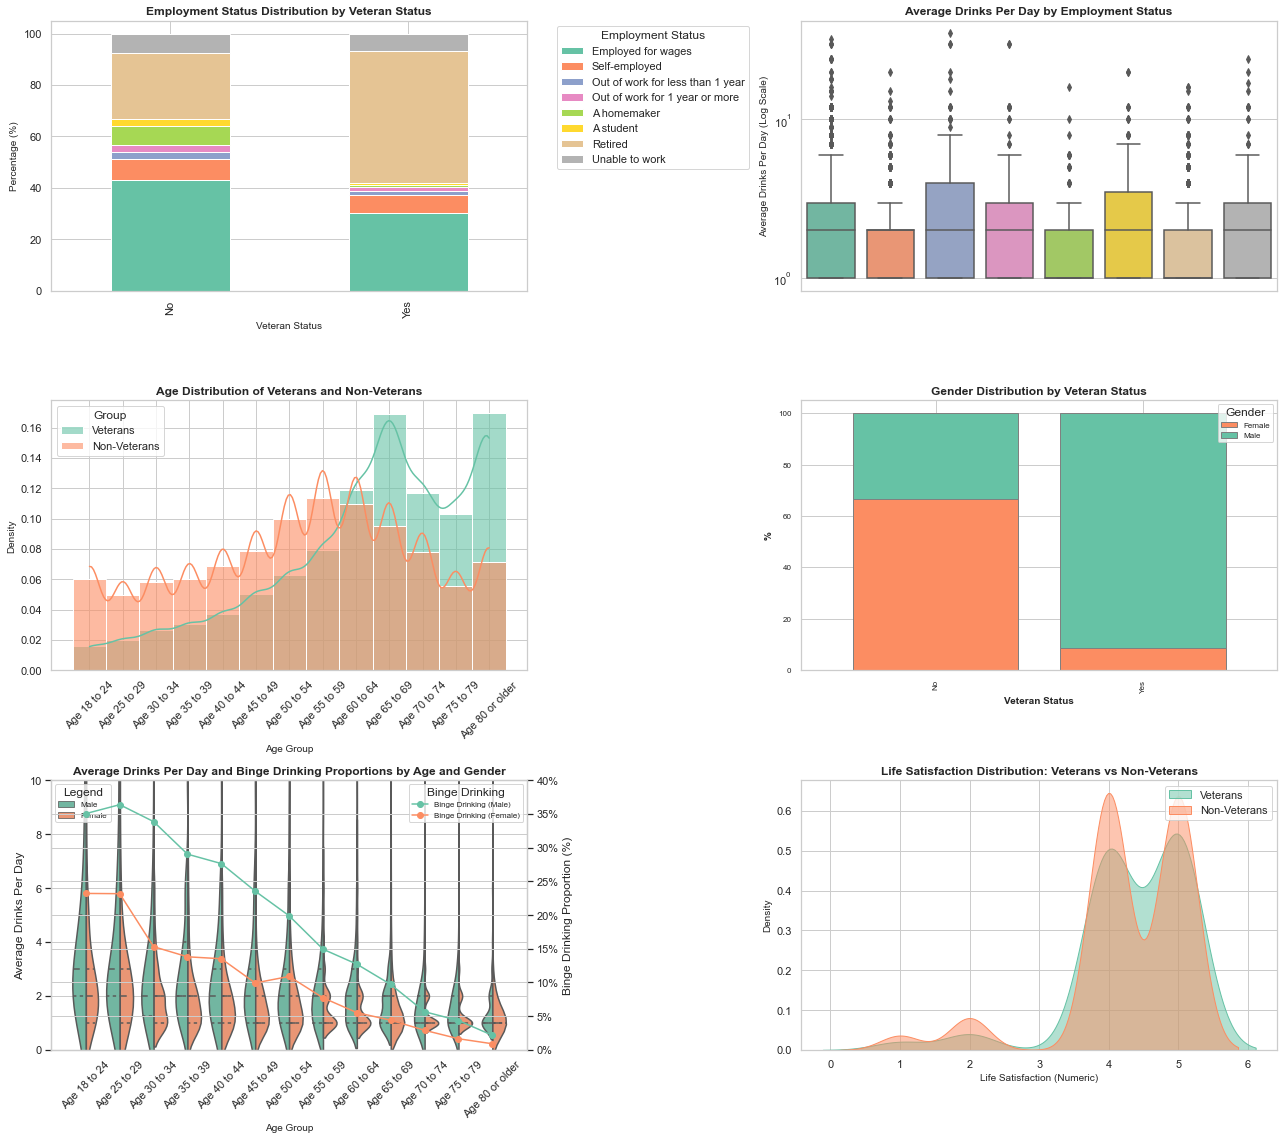

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Stacked bar chart for employment status distribution
employment_percentages[employment_order].plot(kind='bar', stacked=True, ax=axes[0, 0], color=palette)
axes[0, 0].set_title('Employment Status Distribution by Veteran Status', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Veteran Status', fontsize=10)
axes[0, 0].set_ylabel('Percentage (%)', fontsize=10)
axes[0, 0].legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Boxplot for average drinks per day by employment status
sns.boxplot(data=df_hypothesis, x='employment', y='avgDrinksDay', palette=palette, ax=axes[0, 1], order=employment_order)
axes[0, 1].set_yscale('log')  # Set the y-axis to a logarithmic scale
axes[0, 1].set_title('Average Drinks Per Day by Employment Status', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('')  # Remove x-axis label
axes[0, 1].set_xticklabels([])  # Remove x-axis tick labels
axes[0, 1].set_ylabel('Average Drinks Per Day (Log Scale)', fontsize=10)

# Plot 3: Histogram for age distribution of veterans and non-veterans
sns.histplot(veterans_data, bins=15, kde=True, color=palette[0], label='Veterans', stat='density', alpha=0.6, ax=axes[1, 0])
sns.histplot(non_veterans_data, bins=15, kde=True, color=palette[1], label='Non-Veterans', stat='density', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution of Veterans and Non-Veterans', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Age Group', fontsize=10)
axes[1, 0].set_ylabel('Density', fontsize=10)
axes[1, 0].legend(title='Group')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Gender Distribution by Veteran Status
grouped_data = df_hypothesis.groupby(['vet', 'sex']).size().unstack()
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
barWidth = 0.8 

grouped_data_percentage.plot(kind='bar', stacked=True, width=barWidth, ax=axes[1, 1], color=[palette[1], palette[0]], edgecolor='grey')
axes[1, 1].set_xlabel('Veteran Status', fontweight='bold', fontsize=10)
axes[1, 1].set_ylabel('%', fontweight='bold', fontsize=10)
axes[1, 1].set_title('Gender Distribution by Veteran Status', fontweight='bold', fontsize=12)
axes[1, 1].tick_params(axis='both', labelsize=8)
axes[1, 1].legend(title='Gender', labels=['Female', 'Male'], fontsize=8)

# Plot 5: Average Drinks Per Day and Binge Drinking Proportions by Age and Gender
ax1 = axes[2, 0]

# Violin plot for avgDrinksDay on the primary y-axis
sns.violinplot(
    data=df_hypothesis,
    x='age',
    y='avgDrinksDay',
    hue='sex',
    split=True, 
    palette='Set2',
    scale='count', 
    inner='quartile',  
    ax=ax1,
    order=sorted(df_hypothesis['age'].unique())
)

# Customize the primary y-axis
ax1.set_ylabel('Average Drinks Per Day', fontsize=12)
ax1.set_ylim(0, 10)

# Create a secondary y-axis for the line plot
ax2 = ax1.twinx()

# Overlay line plot for binge drinking proportions on the secondary y-axis
for gender, color in zip(['Male', 'Female'], sns.color_palette('Set2', 2)):
    gender_data = binge_drinking_distribution[binge_drinking_distribution['sex'] == gender]
    ax2.plot(
        gender_data['age'],
        gender_data['Proportion'] * 100,
        label=f'Binge Drinking ({gender})',
        color=color,
        marker='o'
    )

# Customize  secondary y-axis
ax2.set_ylabel('Binge Drinking Proportion (%)', fontsize=12)
ax2.set_ylim(0, 40)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))


ax1.set_title('Average Drinks Per Day and Binge Drinking Proportions by Age and Gender', fontweight='bold', fontsize=12)
ax1.set_xlabel('Age Group', fontsize=10)
ax1.legend(title='Legend', fontsize=8, loc='upper left')
ax2.legend(title='Binge Drinking', fontsize=8, loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# Plot 6: Life Satisfaction Distribution: Veterans vs Non-Veterans
sns.kdeplot(
    veterans_life_satisfaction,
    label='Veterans',
    fill=True,
    color=palette[0],
    alpha=0.5,
    ax=axes[2, 1]
)
sns.kdeplot(
    non_veterans_life_satisfaction,
    label='Non-Veterans',
    fill=True,
    color=palette[1],
    alpha=0.5,
    ax=axes[2, 1]
)
axes[2, 1].set_title('Life Satisfaction Distribution: Veterans vs Non-Veterans', fontweight='bold', fontsize=12)
axes[2, 1].set_xlabel('Life Satisfaction (Numeric)', fontsize=10)
axes[2, 1].set_ylabel('Density', fontsize=10)
axes[2, 1].legend()
¡
plt.tight_layout()
plt.show()


---

## 4. Inference statistics
In this section, perform a statistical analysis on the data to respond to the research questions
proposed in section 1. You have to answer at least one question via confidence interval and at
least one question via hypothesis testing. Alternatively, you can answer one of the questions
using a Bayesian model. 

### 4.1. CI Statistics

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Compute Cramér's V for all categorical variables
def cramers_v_for_all(df, target='cost_barrier_label'):
    results = {}
    for col in df.select_dtypes(include='category').columns:
        if col == target:
            continue
        try:
            table = pd.crosstab(df[col], df[target])
            v = cramers_v(table)
            results[col] = v
        except:
            continue
    return pd.Series(results).sort_values(ascending=False)

# Compute Eta Squared for continuous variables
def compute_eta_squared(df, numeric_col, group_col='cost_barrier_label'):
    df_filtered = df[[numeric_col, group_col]].dropna()
    model = ols(f"{numeric_col} ~ C({group_col})", data=df_filtered).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    ss_between = anova_table['sum_sq'][0]
    ss_total = sum(anova_table['sum_sq'])
    return ss_between / ss_total  # η²

# --- Example execution (replace df_plot with your actual dataframe) ---
categorical_results = cramers_v_for_all(df_plot)

continuous_results = {
    'physically_unwell_days': compute_eta_squared(df_plot, 'physically_unwell_days'),
    'mentally_unwell_days': compute_eta_squared(df_plot, 'mentally_unwell_days'),
    'activity_limited_days': compute_eta_squared(df_plot, 'activity_limited_days')
}

# Display results
print("Cramér's V (categorical variables):")
print(categorical_results)
print("Pick the ones with Cramér's V > 0.15")

print("\nEta Squared (continuous variables):")
print(continuous_results)

Cramér's V (categorical variables):
insurance_label     0.358819
income_label        0.252709
employment_label    0.227665
health_label        0.188705
age_label           0.175031
doctor_label        0.153656
education_label     0.138229
dtype: float64
Pick the ones with Cramér's V > 0.15

Eta Squared (continuous variables):
{'physically_unwell_days': 0.020098062463328015, 'mentally_unwell_days': 0.047457885353933006, 'activity_limited_days': 0.01760707201610567}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from scipy.stats import ttest_ind

categorical_vars = ['insurance_label', 'income_label', 'employment_label', 'health_label', 'age_label', 'doctor_label']

ci_results = []

for var in categorical_vars:
    grouped = (
        df_plot.groupby(var)['cost_barrier_label']
        .value_counts(normalize=False)
        .unstack()
        .fillna(0)
    )
    grouped['total'] = grouped.sum(axis=1)
    grouped['prop_yes'] = grouped['Yes'] / grouped['total']
    grouped['ci_low'], grouped['ci_upp'] = zip(*[
        proportion_confint(count=row['Yes'], nobs=row['total'], method='wilson')
        for _, row in grouped.iterrows()
    ])
    grouped[var] = grouped.index
    grouped['variable'] = var
    ci_results.append(grouped.reset_index(drop=True))

ci_combined = pd.concat(ci_results, ignore_index=True)
ci_combined

cost_barrier_label,No,Yes,total,prop_yes,ci_low,ci_upp,insurance_label,variable,income_label,employment_label,health_label,age_label,doctor_label
0,33909,3043,36952,0.082350,0.079590,0.085197,Insured,insurance_label,NaN,NaN,NaN,NaN,NaN
1,2605,2176,4781,0.455135,0.441061,0.469281,Uninsured,insurance_label,NaN,NaN,NaN,NaN,NaN
2,11162,398,11560,0.034429,0.031257,0.037910,NaN,income_label,≥75K,NaN,NaN,NaN,NaN
3,6059,446,6505,0.068563,0.062673,0.074962,NaN,income_label,<75K,NaN,NaN,NaN,NaN
4,5493,634,6127,0.103476,0.096097,0.111353,NaN,income_label,<50K,NaN,NaN,NaN,NaN
5,4135,728,4863,0.149702,0.139951,0.160006,NaN,income_label,<35K,NaN,NaN,NaN,NaN
6,3311,836,4147,0.201592,0.189660,0.214076,NaN,income_label,<25K,NaN,NaN,NaN,NaN
7,2646,815,3461,0.235481,0.221643,0.249905,NaN,income_label,<20K,NaN,NaN,NaN,NaN
8,1986,670,2656,0.252259,0.236108,0.269126,NaN,income_label,<15K,NaN,NaN,NaN,NaN
9,1808,708,2516,0.281399,0.264171,0.299293,NaN,income_label,<10K,NaN,NaN,NaN,NaN


In [ ]:
# T-tests para variables continuas
continuous_vars = ['mentally_unwell_days', 'physically_unwell_days', 'activity_limited_days']
ttest_results = []

for var in continuous_vars:
    group_yes = df_plot[df_plot['cost_barrier_label'] == 'Yes'][var].dropna()
    group_no = df_plot[df_plot['cost_barrier_label'] == 'No'][var].dropna()
    t_stat, p_val = ttest_ind(group_yes, group_no, equal_var=False)
    ttest_results.append({
        'Variable': var,
        'Mean (Yes)': group_yes.mean(),
        'Mean (No)': group_no.mean(),
        't-stat': t_stat,
        'p-value': p_val
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df

,Variable,Mean (Yes),Mean (No),t-stat,p-value
0,mentally_unwell_days,7.854980,2.776622,32.504396,6.361368e-213
1,physically_unwell_days,7.576053,3.810391,23.975883,2.056123e-121
2,activity_limited_days,7.900927,4.666610,17.406798,6.369917e-66


In [ ]:
from scipy.stats import norm

# 95% confidence level
z = norm.ppf(0.975)  # ~1.96

def compute_ci(df, group_col, response_col='cost_barrier_label', positive_label='Yes'):
    results = []
    for group, subset in df.groupby(group_col):
        n = len(subset)
        x = (subset[response_col] == positive_label).sum()
        p_hat = x / n
        se = np.sqrt((p_hat * (1 - p_hat)) / n)
        ci_low = p_hat - z * se
        ci_high = p_hat + z * se
        results.append({
            group_col: group,
            'n': n,
            'count_yes': x,
            'proportion': p_hat,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        })
    return pd.DataFrame(results).sort_values(by='proportion', ascending=False)

age_order = [
    '18-24', '25-29', '30-34', '35-39', '40-44',
    '45-49', '50-54', '55-59', '60-64', '65-69',
    '70-74', '75-79', '80+'
]

df_plot['cost_barrier_label'] = df_plot['cost_barrier_label'].astype('category')
df_plot['income_label'] = df_plot['income_label'].cat.remove_unused_categories()
df_plot['education_label'] = df_plot['education_label'].cat.remove_unused_categories()
df_plot['employment_label'] = df_plot['employment_label'].cat.remove_unused_categories()
df_plot['sex_label'] = df_plot['sex_label'].astype('category')
df_plot['age_label'] = pd.Categorical(df_plot['age_label'], categories=age_order, ordered=True)

ci_income = compute_ci(df_plot, 'income_label')
ci_education = compute_ci(df_plot, 'education_label')
ci_employment = compute_ci(df_plot, 'employment_label')
ci_sex = compute_ci(df_plot, 'sex_label')
ci_age = compute_ci(df_plot, 'age_label')
ci_age['age_label'] = pd.Categorical(ci_age['age_label'], categories=age_order, ordered=True)
ci_age = ci_age.sort_values('age_label')
ci_physically_unwell_days = compute_ci(df_plot, 'physically_unwell_days')
ci_mentally_unwell_days = compute_ci(df_plot, 'mentally_unwell_days')
ci_activity_limited_days = compute_ci(df_plot, 'activity_limited_days')

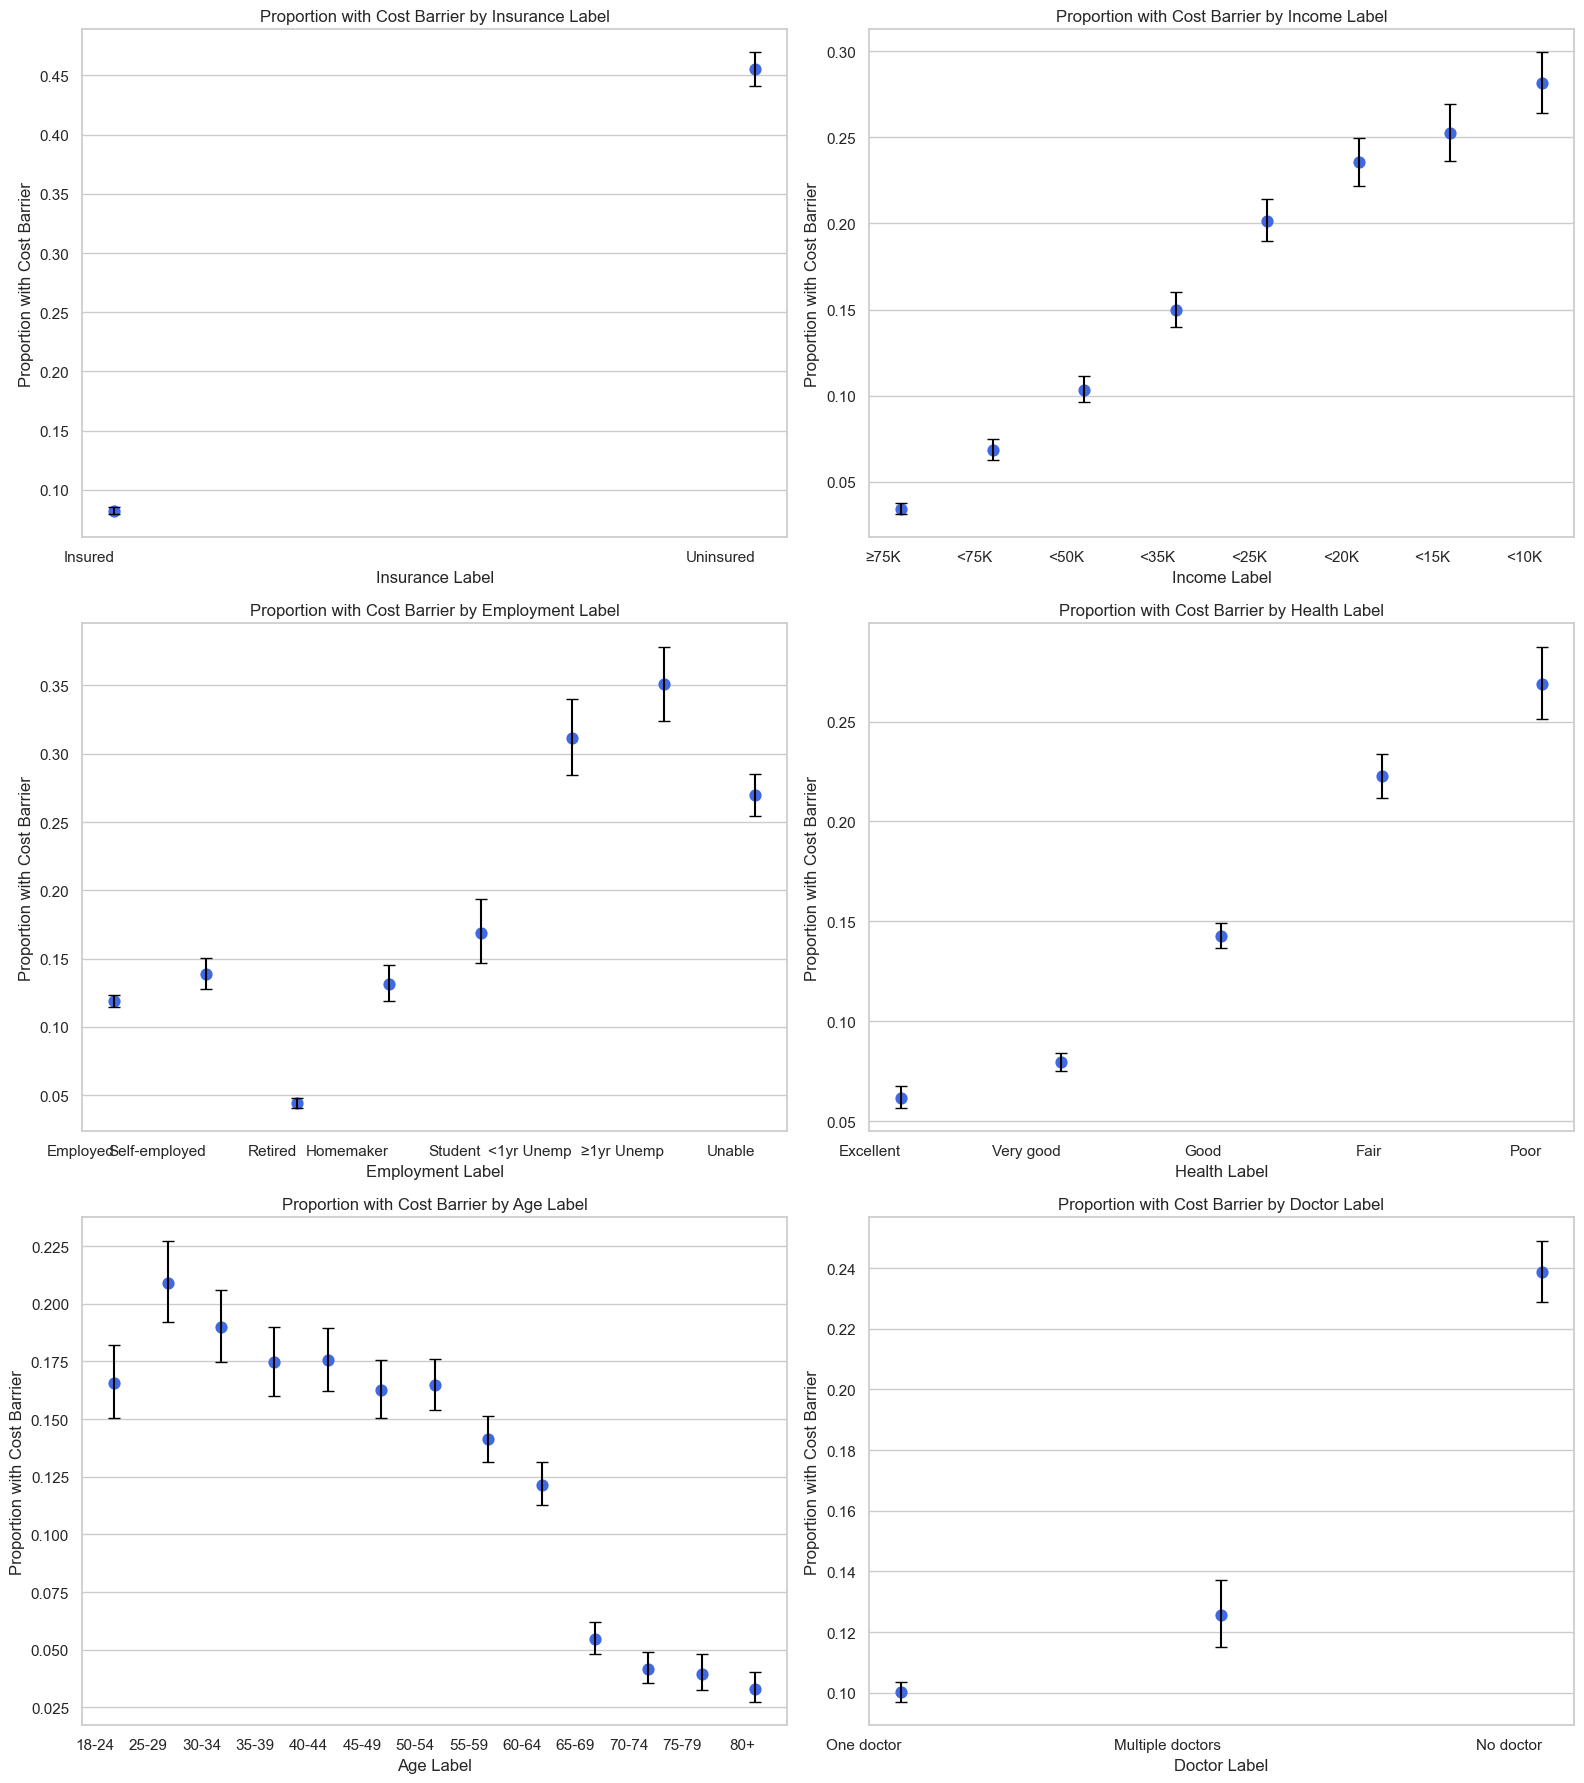

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

# Variables
categorical_vars = ['insurance_label', 'income_label', 'employment_label', 'health_label', 'age_label', 'doctor_label']

# Prepare graphs for CI
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for idx, var in enumerate(categorical_vars):
    grouped = (
        df_plot.groupby(var)['cost_barrier_label']
        .value_counts(normalize=False)
        .unstack()
        .fillna(0)
    )
    grouped['total'] = grouped.sum(axis=1)
    grouped['prop_yes'] = grouped['Yes'] / grouped['total']
    grouped['ci_low'], grouped['ci_upp'] = zip(*[
        proportion_confint(count=row['Yes'], nobs=row['total'], method='wilson')
        for _, row in grouped.iterrows()
    ])
    grouped['err_low'] = grouped['prop_yes'] - grouped['ci_low']
    grouped['err_upp'] = grouped['ci_upp'] - grouped['prop_yes']

    # Plot
    ax = axes[idx]
    sns.pointplot(
        x=grouped.index,
        y=grouped['prop_yes'],
        ax=ax,
        join=False,
        color='royalblue'
    )
    ax.errorbar(
        x=range(len(grouped)),
        y=grouped['prop_yes'],
        yerr=[grouped['err_low'], grouped['err_upp']],
        fmt='none',
        c='black',
        capsize=4
    )
    ax.set_title(f'Proportion with Cost Barrier by {var.replace("_", " ").title()}')
    ax.set_ylabel('Proportion with Cost Barrier')
    ax.set_xlabel(var.replace("_", " ").title())
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels(grouped.index, ha='right')

plt.tight_layout()
plt.show()

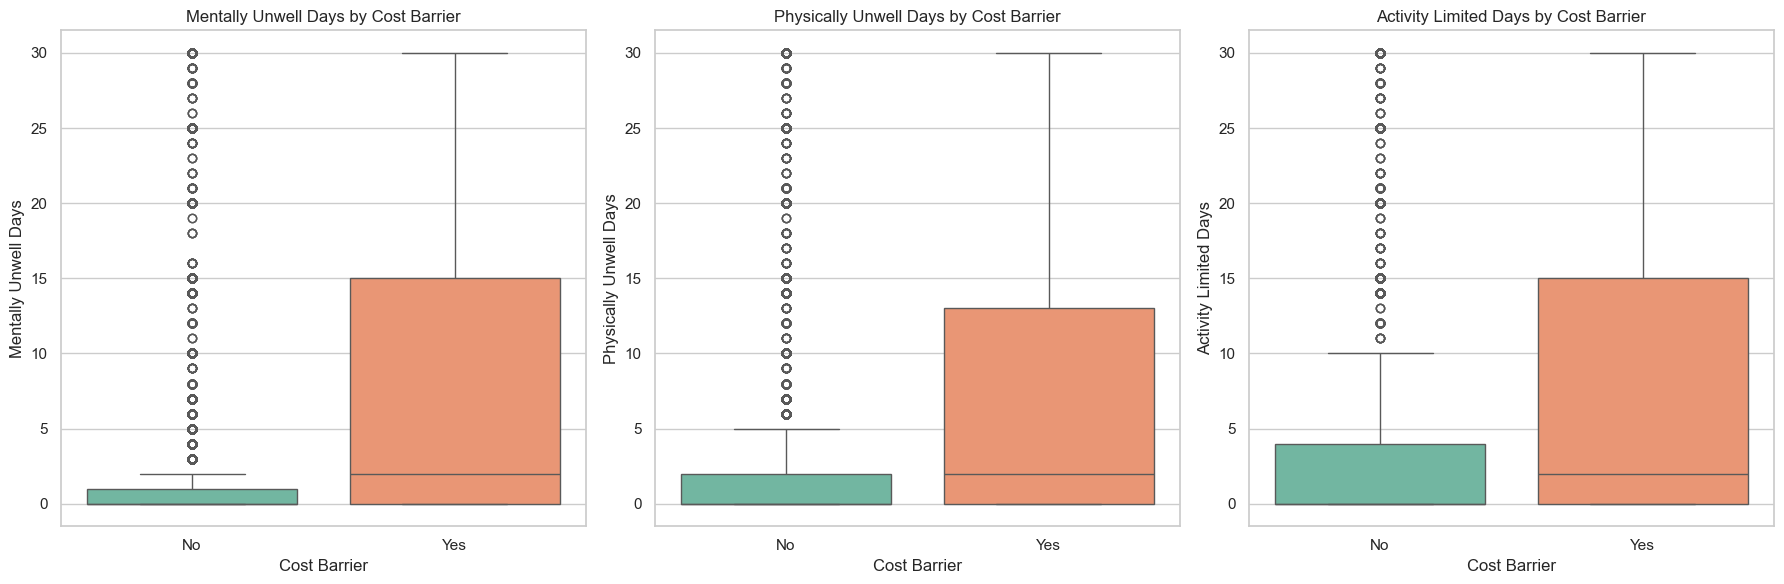

In [ ]:
# Variables
continuous_vars = ['mentally_unwell_days', 'physically_unwell_days', 'activity_limited_days']

# Boxplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for idx, var in enumerate(continuous_vars):
    ax = axes[idx]
    sns.boxplot(data=df_plot, x='cost_barrier_label', y=var, ax=ax, palette='Set2')
    ax.set_title(f'{var.replace("_", " ").title()} by Cost Barrier')
    ax.set_xlabel('Cost Barrier')
    ax.set_ylabel(var.replace("_", " ").title())

plt.tight_layout()
plt.show()


### 4.2. Hypothesis Testing Statistics

## Inference for two proportions

In [175]:
import numpy as np
from scipy import stats

# Sample data
sample_size_vet = len(df_hypothesis[df_hypothesis['vet'] == 'Yes'])
sample_size_non_vet = len(df_hypothesis[df_hypothesis['vet'] == 'No'])
sample_count_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'Yes') & (df_hypothesis['bingeDrinking'] == 'Yes')])
sample_count_non_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'No') & (df_hypothesis['bingeDrinking'] == 'Yes')])

# Sample proportions
sample_p_vet = sample_count_vet_heavy / sample_size_vet
sample_p_non_vet = sample_count_non_vet_heavy / sample_size_non_vet

# Pooled proportion
p_pooled = (sample_count_vet_heavy + sample_count_non_vet_heavy) / (sample_size_vet + sample_size_non_vet)

# Standard error
sample_std = np.sqrt(p_pooled * (1 - p_pooled) * (1 / sample_size_vet + 1 / sample_size_non_vet))

# Z-score
z_score = (sample_p_vet - sample_p_non_vet) / sample_std

# Test type
test_type = 'one-sided'  # One-sided test for p_vet > p_non_vet

# Calculate p-value
if test_type == 'two-sided':
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test
elif test_type == 'one-sided':
    p_value = (1 - stats.norm.cdf(abs(z_score))) # One-tailed test

# Significance level
alpha = 0.05

# Results
print("Z-score:", z_score)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. Veterans have a higher proportion of binge drinking.")
else:
    print("Fail to reject the null hypothesis. No significant evidence that veterans have a higher proportion of binge drinking.")

Z-score: -1.433052953696358
P-value: 0.07592135241650688
Fail to reject the null hypothesis. No significant evidence that veterans have a higher proportion of binge drinking.


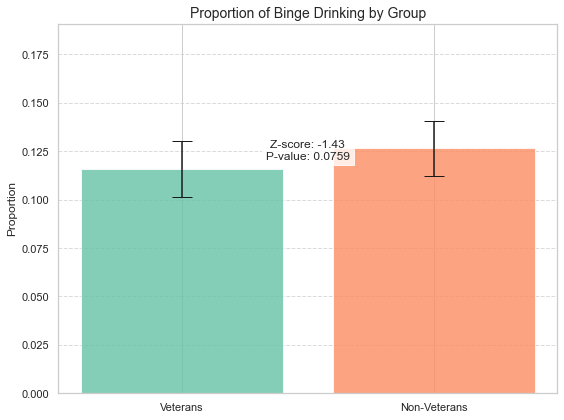

In [ ]:
groups = ['Veterans', 'Non-Veterans']
proportions = [sample_p_vet, sample_p_non_vet]
errors = [1.96 * sample_std, 1.96 * sample_std]  # 95% confidence intervals

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(groups, proportions, yerr=errors, capsize=10, color=[palette[0], palette[1]], alpha=0.8)
ax.set_title('Proportion of Binge Drinking by Group', fontsize=14)
ax.set_ylabel('Proportion', fontsize=12)
ax.set_ylim(0, max(proportions) + max(errors) + 0.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

text = f"Z-score: {z_score:.2f}\nP-value: {p_value:.4f}"
ax.text(0.5, max(proportions) + max(errors) - 0.02, text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()